In [3]:
import pandas as pd
import zipfile
from datetime import timedelta

# --------------------------------------------------
# Configuration (paths, chunk sizes, etc.)(This part tells the program where the MIMIC data is stored and how much data to read at a time.)
# --------------------------------------------------
zip_path = r"E:\Universität\Winter semester 25\Data science\mimic documentation\mimic-iii-clinical-database-1.4.zip"
# small tables can be loaded at once; large ones must be streamed

MAX_ROWS_SMALL = None          # all rows for small tables
CHUNK_SIZE = 500_000           # rows per chunk when streaming events
print("this section was scuccessfully executed")

this section was scuccessfully executed


In [4]:
# --------------------------------------------------
#  Define which ITEMIDs correspond to the vitals/labs we need(Lists all the ICU vital signs and lab test codes we want to extract from CHARTEVENTS and LABEVENTS)
# --------------------------------------------------

# VITALS (from CHARTEVENTS)
vital_itemids = {
    "HR":      [211, 220045],                               # Heart rate
    "SBP":     [51, 442, 455, 6701, 220179, 220050],        # Systolic blood pressure (multiple variants)
    "RR":      [618, 220210],                               # Respiratory rate
    "Temp":    [676, 223761],                               # Body temperature
    "SpO2":    [646, 220277],                               # Oxygen saturation
    "GCS":     [454, 223900],                               # Glasgow Coma Scale components
}
# LABS (from LABEVENTS)
lab_itemids = {
    "Lactate":     [50813],   # blood lactate level
    "Creatinine":  [50912],   # kidney function marker
    "BUN":         [51006],   # blood urea nitrogen
    "WBC":         [51300],   # white blood cell count
    "HGB":         [50811],   # hemoglobin
    "Platelets":   [51265],   # platelet count
    "Sodium":      [50983],   # serum sodium
    "Potassium":   [50971],   # serum potassium
    "Bicarbonate": [50882],   # serum bicarbonate (CO₂)
    "AG":         [50868],    # anion gap 
    "Bilirubin":   [50885],   # total bilirubin (liver function, very predictive)
}

# flatten ITEMID lists for filtering
vital_itemids_all = [x for ids in vital_itemids.values() for x in ids]
lab_itemids_all   = [x for ids in lab_itemids.values()   for x in ids]
print("this section was scuccessfully executed")


this section was scuccessfully executed


In [5]:
# --------------------------------------------------
# Helper function for small tables (loads from ZIP) (This part loads the smaller MIMIC tables directly from the ZIP file because they are easy to load)
# --------------------------------------------------
def load_from_zip(zip_path, pattern, usecols, nrows=None):
    """Load a single .csv.gz whose filename contains `pattern` from a ZIP."""
    with zipfile.ZipFile(zip_path, "r") as z:
        member = [m for m in z.namelist()
                  if pattern in m and m.endswith(".csv.gz")][0]
        with z.open(member) as f:
            return pd.read_csv(
                f,
                compression="gzip",
                usecols=usecols,
                nrows=nrows,
                low_memory=False
            )
            
print("this section was scuccessfully executed")

this section was scuccessfully executed


In [6]:
# --------------------------------------------------
# Helper: load BIG events table in chunks and filter by ITEMID + cohort IDs
# (Reads a very large events table in pieces and keeps only the 
#  rows we need: specific ITEMIDs AND our cohort HADM_ID/ICUSTAY_ID.)
# --------------------------------------------------
def load_events_filtered(
    zip_path,
    pattern,
    usecols,
    item_col,
    keep_itemids,
    valid_hadm_ids=None,        # [ADDED]  list/array of cohort HADM_IDs
    valid_icustay_ids=None,     # [ADDED]  list/array of cohort ICUSTAY_IDs
    chunksize=CHUNK_SIZE,
):
    """
    Stream a large events table from zip, keeping only rows with:
      - item_col in keep_itemids
      - optional HADM_ID in valid_hadm_ids
      - optional ICUSTAY_ID in valid_icustay_ids
    """

    with zipfile.ZipFile(zip_path, "r") as z:
        # [CHANGED] safer file lookup: list all matches and check
        #   reason: avoid IndexError if pattern not found; give clear error instead.
        members = [
            m for m in z.namelist()
            if pattern in m and m.endswith(".csv.gz")
        ]
        if not members:
            raise FileNotFoundError(
                f"No file with pattern '{pattern}' found in {zip_path}"
            )
        member = members[0]

        chunks = []
        with z.open(member) as f:
            reader = pd.read_csv(
                f,
                compression="gzip",
                usecols=usecols,
                chunksize=chunksize,
                low_memory=False,
            )

            for chunk in reader:
                # start: filter by ITEMID (as before)
                mask = chunk[item_col].isin(keep_itemids)

                # [ADDED] optionally filter by cohort HADM_IDs
                #   reason: avoid keeping rows from admissions not in our cohort.
                if valid_hadm_ids is not None and "HADM_ID" in chunk.columns:
                    mask &= chunk["HADM_ID"].isin(valid_hadm_ids)

                # [ADDED] optionally filter by cohort ICUSTAY_IDs
                #   reason: avoid keeping rows from ICU stays not in our cohort.
                if valid_icustay_ids is not None and "ICUSTAY_ID" in chunk.columns:
                    mask &= chunk["ICUSTAY_ID"].isin(valid_icustay_ids)

                chunk = chunk[mask]

                if not chunk.empty:
                    chunks.append(chunk)

    if chunks:
        return pd.concat(chunks, ignore_index=True)
    else:
        # return empty frame with correct columns
        return pd.DataFrame(columns=usecols)

print("load_events_filtered section was successfully executed")


load_events_filtered section was successfully executed


In [7]:

# --------------------------------------------------
# Load core tables (small)(Loads PATIENTS, ADMISSIONS, ICUSTAYS, PRESCRIPTIONS from the ZIP file.)
# --------------------------------------------------
patients = load_from_zip(
    zip_path,
    "PATIENTS",
    ["SUBJECT_ID", "DOB", "GENDER", "DOD"],    #  DOD for Mortality_inhospital calculation 
    MAX_ROWS_SMALL,
)

admissions = load_from_zip(
    zip_path,
    "ADMISSIONS",
    ["SUBJECT_ID", "HADM_ID", "ADMISSION_TYPE", "ADMISSION_LOCATION",
     "ADMITTIME", "DISCHTIME", "DEATHTIME",    #  DISCHTIME & DEATHTIME for Mortality_inhospital calculation
     "INSURANCE", "ETHNICITY", "DIAGNOSIS",
     "HOSPITAL_EXPIRE_FLAG"],
    MAX_ROWS_SMALL,
)

icustays = load_from_zip(
    zip_path,
    "ICUSTAYS",
    ["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID",
     "INTIME", "OUTTIME", "LOS",
     "FIRST_CAREUNIT", "LAST_CAREUNIT",
     "FIRST_WARDID", "LAST_WARDID"],
    MAX_ROWS_SMALL,
)

prescriptions = load_from_zip(
    zip_path,
    "PRESCRIPTIONS",
    ["HADM_ID", "DRUG"],
    MAX_ROWS_SMALL,
)
print("this section was scuccessfully executed")

this section was scuccessfully executed


In [8]:
# --------------------------------------------------
# Convert date/time columns to datetime(Converts text timestamps to real datetime objects so we can compare times mathematically.)
# --------------------------------------------------
patients["DOB"]       = pd.to_datetime(patients["DOB"], errors="coerce")
patients["DOD"]       = pd.to_datetime(patients["DOD"], errors="coerce")
admissions["ADMITTIME"]  = pd.to_datetime(admissions["ADMITTIME"], errors="coerce")
admissions["DISCHTIME"]  = pd.to_datetime(admissions["DISCHTIME"], errors="coerce")
admissions["DEATHTIME"]  = pd.to_datetime(admissions["DEATHTIME"], errors="coerce")
icustays["INTIME"]    = pd.to_datetime(icustays["INTIME"], errors="coerce")
icustays["OUTTIME"]   = pd.to_datetime(icustays["OUTTIME"], errors="coerce")

print("this section was scuccessfully executed") 

this section was scuccessfully executed


In [9]:
# --------------------------------------------------
# Apply ICU-level exclusion criteria BEFORE building cohort
# --------------------------------------------------

# Remove ICU transfers: same ward and same careunit (Keep only patients who stayed in the same ICU (no transfers), because transfers make early prediction unreliable.)

icustays = icustays[
    icustays["FIRST_CAREUNIT"].notna() &
    icustays["LAST_CAREUNIT"].notna() &
    (icustays["FIRST_CAREUNIT"] == icustays["LAST_CAREUNIT"]) &  ## Exclude real ICU transfers; ignore missing ward/careunit values
    icustays["FIRST_WARDID"].notna() &
    icustays["LAST_WARDID"].notna() &
    (icustays["FIRST_WARDID"] == icustays["LAST_WARDID"])
]


# Remove stays with LOS < 2 days (48 hours)(Keep only ICU stays that lasted 48 hours or more, because your project analyzes first 48 hours of data)
icustays = icustays[icustays["LOS"] >= 2.0]

# Remove admissions with multiple ICU stays(Keep only ONE ICU stay per hospital admission to avoid double-counting the same patient)
hadm_counts = icustays["HADM_ID"].value_counts()
single_hadm_ids = hadm_counts[hadm_counts == 1].index
icustays = icustays[icustays["HADM_ID"].isin(single_hadm_ids)]
print("this section was scuccessfully executed") 

this section was scuccessfully executed


In [10]:
# --------------------------------------------------
# Build base cohort (one row per HADM_ID(hospital admission) / Earlier ICU stay)(Merges PATIENTS + ADMISSIONS + ICUSTAYS so each row represents one ICU stay with demographic + admission info.)
# --------------------------------------------------
cohort = (
    icustays
    .merge(patients, on="SUBJECT_ID", how="left")
    .merge(admissions, on=["SUBJECT_ID", "HADM_ID"], how="left")
)

# remove entries missing DOB/INTIME because age can't be calculated
cohort = cohort.dropna(subset=["INTIME", "DOB"])

# Age at ICU admission (year-based to avoid overflow)

cohort["AGE"] = cohort["INTIME"].dt.year - cohort["DOB"].dt.year

# Apply MIMIC rule: ages > 89 are masked, set to 90
cohort.loc[cohort["AGE"] > 89, "AGE"] = 90


# Remove pediatric patients (< 18 years)
cohort = cohort[cohort["AGE"] >= 18]

# Keep only first ICU stay per hospital admission (extra safety)/if a patient had multiple ICU stays in the same admission, keep earliest for early mortality prediction
cohort1 = (
    cohort.sort_values(["HADM_ID", "INTIME"])
          .drop_duplicates(subset=["HADM_ID"], keep="first")
)
print("Cohort shape:", cohort.shape)
print("Cohort1 shape:", cohort1.shape)


print("this section was scuccessfully executed") 


Cohort shape: (22365, 23)
Cohort1 shape: (22365, 23)
this section was scuccessfully executed


In [11]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
cohort1.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,AGE
19748,58526,100001,275225,MICU,MICU,52,52,2117-09-11 11:47:35,2117-09-15 17:57:14,4.2567,F,2082-03-21,NaT,2117-09-11 11:46:00,2117-09-17 16:45:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,Private,WHITE,DIABETIC KETOACIDOSIS,0,35
5316,9895,100006,291788,MICU,MICU,15,15,2108-04-06 15:50:15,2108-04-11 15:18:03,4.9776,F,2059-05-07,2109-10-24,2108-04-06 15:49:00,2108-04-18 17:18:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,Private,BLACK/AFRICAN AMERICAN,COPD FLARE,0,49
482,533,100009,253656,CSRU,CSRU,15,15,2162-05-17 10:18:31,2162-05-19 22:05:14,2.4908,M,2101-07-30,NaT,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Private,WHITE,CORONARY ARTERY DISEASE,0,61
24180,87977,100011,214619,TSICU,TSICU,14,14,2177-08-29 04:52:21,2177-09-09 16:56:35,11.5029,M,2156-02-27,NaT,2177-08-29 04:51:00,2177-09-12 14:24:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicaid,HISPANIC OR LATINO,MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES,0,21
21075,58128,100018,269533,SICU,SICU,33,33,2176-08-29 16:56:37,2176-09-02 15:04:36,3.9222,M,2121-02-13,2177-09-28,2176-08-29 10:30:00,2176-09-06 17:13:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,WHITE,HERNIATED DISC/SDA,0,55


In [12]:
# --------------------------------------------------
# Load CHARTEVENTS & LABEVENTS filtered by ITEMID and cohort IDs
# --------------------------------------------------

# First, get the IDs from the cohort we already built
valid_hadm_ids = cohort1["HADM_ID"].unique()
valid_icustay_ids = cohort1["ICUSTAY_ID"].unique()

# Columns we need from each big table
chart_usecols = ["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "ITEMID", "CHARTTIME", "VALUENUM"]
lab_usecols   = ["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUENUM"]

# CHARTEVENTS
chartevents = load_events_filtered(
    zip_path=zip_path,
    pattern="CHARTEVENTS",
    usecols=chart_usecols,
    item_col="ITEMID",
    keep_itemids=vital_itemids_all,
    valid_hadm_ids=valid_hadm_ids,
    valid_icustay_ids=valid_icustay_ids,
)

# LABEVENTS
labevents = load_events_filtered(
    zip_path=zip_path,
    pattern="LABEVENTS",
    usecols=lab_usecols,
    item_col="ITEMID",
    keep_itemids=lab_itemids_all,
    valid_hadm_ids=valid_hadm_ids,
    valid_icustay_ids=None,  # LABEVENTS usually has no ICUSTAY_ID
)
labevents["CHARTTIME"]   = pd.to_datetime(labevents["CHARTTIME"], errors="coerce")
chartevents["CHARTTIME"] = pd.to_datetime(chartevents["CHARTTIME"], errors="coerce")
print("Filtered LABEVENTS shape:", labevents.shape)
print("Filtered CHARTEVENTS shape:", chartevents.shape)
print("CHARTEVENTS & LABEVENTS loading section was successfully executed")


Filtered LABEVENTS shape: (2592865, 5)
Filtered CHARTEVENTS shape: (16247983, 6)
CHARTEVENTS & LABEVENTS loading section was successfully executed


In [14]:
# --------------------------------------------------
# Define in-hospital mortality using timestamps(Determines whether the patient died inside the hospital based on DOD or DEATHTIME occurring between ADMITTIME and DISCHTIME.)
# --------------------------------------------------
death_by_dod = (
    cohort1["DOD"].notna() &
    (cohort1["DOD"] >= cohort1["ADMITTIME"]) &
    (cohort1["DOD"] <= cohort1["DISCHTIME"])
)

death_by_deathtime = (
    cohort1["DEATHTIME"].notna() &
    (cohort1["DEATHTIME"] >= cohort1["ADMITTIME"]) &
    (cohort1["DEATHTIME"] <= cohort1["DISCHTIME"])
)
cohort2 = cohort1.copy()
cohort2["MORTALITY_INHOSPITAL"] = (death_by_dod | death_by_deathtime).astype(int)
print("this section was scuccessfully executed") 


this section was scuccessfully executed


In [15]:
# ------------------------------------------
# Sanity check: compare to HOSPITAL_EXPIRE_FLAG
# ------------------------------------------
if "HOSPITAL_EXPIRE_FLAG" in cohort.columns:
    mismatch = (cohort2["MORTALITY_INHOSPITAL"] != cohort1["HOSPITAL_EXPIRE_FLAG"])
    print("Mortality label mismatches:", mismatch.sum())
else:
    print("HOSPITAL_EXPIRE_FLAG not available in cohort for comparison.")


Mortality label mismatches: 70


In [16]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
cohort2.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,AGE,MORTALITY_INHOSPITAL
19748,58526,100001,275225,MICU,MICU,52,52,2117-09-11 11:47:35,2117-09-15 17:57:14,4.2567,F,2082-03-21,NaT,2117-09-11 11:46:00,2117-09-17 16:45:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,Private,WHITE,DIABETIC KETOACIDOSIS,0,35,0
5316,9895,100006,291788,MICU,MICU,15,15,2108-04-06 15:50:15,2108-04-11 15:18:03,4.9776,F,2059-05-07,2109-10-24,2108-04-06 15:49:00,2108-04-18 17:18:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,Private,BLACK/AFRICAN AMERICAN,COPD FLARE,0,49,0
482,533,100009,253656,CSRU,CSRU,15,15,2162-05-17 10:18:31,2162-05-19 22:05:14,2.4908,M,2101-07-30,NaT,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Private,WHITE,CORONARY ARTERY DISEASE,0,61,0
24180,87977,100011,214619,TSICU,TSICU,14,14,2177-08-29 04:52:21,2177-09-09 16:56:35,11.5029,M,2156-02-27,NaT,2177-08-29 04:51:00,2177-09-12 14:24:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicaid,HISPANIC OR LATINO,MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES,0,21,0
21075,58128,100018,269533,SICU,SICU,33,33,2176-08-29 16:56:37,2176-09-02 15:04:36,3.9222,M,2121-02-13,2177-09-28,2176-08-29 10:30:00,2176-09-06 17:13:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,WHITE,HERNIATED DISC/SDA,0,55,0


In [17]:
# Define temperature IDs by unit
temp_c_ids = [676]       # Celsius
temp_f_ids = [223761]    # Fahrenheit

# Convert Fahrenheit to Celsius in chartevents
mask_f = chartevents["ITEMID"].isin(temp_f_ids) & chartevents["VALUENUM"].notna()
chartevents.loc[mask_f, "VALUENUM"] = (chartevents.loc[mask_f, "VALUENUM"] - 32.0) * 5.0 / 9.0

# Then define Temp as both IDs
vital_itemids["Temp"] = temp_c_ids + temp_f_ids


In [18]:
# --------------------------------------------------
# Helper: aggregate first-48h stats or Compute min/max/mean for the first 48 hours(For every vital/lab, calculates min, max, mean during the first 48 hours of ICU stay.)
# --------------------------------------------------
def aggregate_first48(events, cohort2, item_map,
                      id_col, time_col, item_col, value_col):
    """
    Aggregate min/max/mean for each variable during the first 48 hours
    after ICU admission.
    """
    base_times = cohort2[[id_col, "INTIME"]].drop_duplicates()
    df = events.merge(base_times, on=id_col, how="inner")

    df = df.dropna(subset=[value_col, time_col, "INTIME"])

    # Restrict to first 48 hours after ICU admission/ limit rows to measurements taken within first 48h
    df = df[
        (df[time_col] >= df["INTIME"]) &
        (df[time_col] <= df["INTIME"] + pd.Timedelta(hours=48))
    ]

    features = cohort2[[id_col]].drop_duplicates().set_index(id_col)

    # compute min/max/mean per variable (Creates columns like HR_min, HR_max, HR_mean, Lactate_min, etc., for each patient.)
    for name, ids in item_map.items():
        sub = df[df[item_col].isin(ids)]
        if sub.empty:
            continue
        agg = (
            sub.groupby(id_col)[value_col]
               .agg(["min", "max", "mean"])
               .rename(columns={
                   "min": f"{name}_min",
                   "max": f"{name}_max",
                   "mean": f"{name}_mean",
               })
        )
        features = features.join(agg, how="left")

    return features.reset_index()
print("this section was scuccessfully executed")

this section was scuccessfully executed


In [19]:
# --------------------------------------------------
# Compute vitals & labs features (first 48h)/ Apply first-48h aggregation for vitals and lab
#(This section filters each patient’s vital signs and lab results to the first 48 hours of ICU stay, summarizes them (min/max/mean), and attaches these features to the main cohort.)
# --------------------------------------------------
# restrict event rows to cohort IDs
chartevents = chartevents[chartevents["ICUSTAY_ID"].isin(cohort2["ICUSTAY_ID"])] #Keep only those vital-sign rows whose ICUSTAY_ID is in our cohort, so every row belongs to one of our selected ICU stays.
labevents   = labevents[labevents["HADM_ID"].isin(cohort2["HADM_ID"])] #Keep only lab result rows whose HADM_ID is in our cohort, so every lab belongs to one of our selected admissions

vital_features = aggregate_first48(
    chartevents, cohort2, vital_itemids,
    id_col="ICUSTAY_ID",
    time_col="CHARTTIME",                #For each ICU stay, calculate min / max / mean of each vital sign in the first 48 hours and store these as one row per ICUSTAY_ID.
    item_col="ITEMID",
    value_col="VALUENUM",
)

lab_features = aggregate_first48(
    labevents, cohort2, lab_itemids,
    id_col="HADM_ID",
    time_col="CHARTTIME",      #For each hospital admission(HAM_ID), calculate min / max / mean of each lab test in the first 48 hours and store these as one row per HADM_ID
    item_col="ITEMID",
    value_col="VALUENUM",
)

cohort3 = (
    cohort2
    .merge(vital_features, on="ICUSTAY_ID", how="left") #Add the 48-hour vital-sign features to the main cohort table by matching rows with the same ICUSTAY_ID
    .merge(lab_features,   on="HADM_ID",   how="left") #Add the 48-hour lab features to the cohort by matching rows with the same HADM_ID, so each patient stay now has all vitals and labs as columns.
)
print("this section was scuccessfully executed") 

this section was scuccessfully executed


In [20]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
cohort3.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,AGE,MORTALITY_INHOSPITAL,HR_min,HR_max,HR_mean,SBP_min,SBP_max,SBP_mean,RR_min,RR_max,RR_mean,Temp_min,Temp_max,Temp_mean,SpO2_min,SpO2_max,SpO2_mean,GCS_min,GCS_max,GCS_mean,Lactate_min,Lactate_max,Lactate_mean,Creatinine_min,Creatinine_max,Creatinine_mean,BUN_min,BUN_max,BUN_mean,WBC_min,WBC_max,WBC_mean,HGB_min,HGB_max,HGB_mean,Platelets_min,Platelets_max,Platelets_mean,Sodium_min,Sodium_max,Sodium_mean,Potassium_min,Potassium_max,Potassium_mean,Bicarbonate_min,Bicarbonate_max,Bicarbonate_mean,AG_min,AG_max,AG_mean,Bilirubin_min,Bilirubin_max,Bilirubin_mean
0,58526,100001,275225,MICU,MICU,52,52,2117-09-11 11:47:35,2117-09-15 17:57:14,4.2567,F,2082-03-21,NaT,2117-09-11 11:46:00,2117-09-17 16:45:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,Private,WHITE,DIABETIC KETOACIDOSIS,0,35,0,90.0,131.0,117.000000,110.0,209.0,176.666667,14.0,22.0,17.300000,36.388889,37.777778,37.152778,96.0,100.0,97.600000,5.0,5.0,5.0,NaN,NaN,NaN,2.0,2.4,2.20,20.0,42.0,31.285714,NaN,NaN,NaN,NaN,NaN,NaN,376.0,407.0,387.000000,138.0,145.0,142.142857,3.3,4.4,3.900000,17.0,23.0,19.857143,11.0,20.0,15.428571,NaN,NaN,NaN
1,9895,100006,291788,MICU,MICU,15,15,2108-04-06 15:50:15,2108-04-11 15:18:03,4.9776,F,2059-05-07,2109-10-24,2108-04-06 15:49:00,2108-04-18 17:18:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,Private,BLACK/AFRICAN AMERICAN,COPD FLARE,0,49,0,86.0,136.0,110.680000,113.0,161.0,136.562500,9.0,29.0,19.000000,NaN,NaN,NaN,79.0,100.0,97.423077,6.0,6.0,6.0,4.5,4.5,4.500,0.6,0.7,0.65,12.0,16.0,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,185.0,204.0,194.500000,131.0,131.0,131.000000,3.7,4.4,4.050000,24.0,26.0,25.000000,8.0,8.0,8.000000,NaN,NaN,NaN
2,533,100009,253656,CSRU,CSRU,15,15,2162-05-17 10:18:31,2162-05-19 22:05:14,2.4908,M,2101-07-30,NaT,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Private,WHITE,CORONARY ARTERY DISEASE,0,61,0,46.0,92.0,67.480000,82.0,138.0,109.042553,0.0,37.0,22.880000,36.500000,37.000000,36.791667,91.0,100.0,96.265306,1.0,5.0,4.0,1.1,1.5,1.300,0.8,0.8,0.80,12.0,13.0,12.500000,NaN,NaN,NaN,11.5,14.6,12.600,125.0,149.0,139.333333,137.0,143.0,140.000000,4.0,4.4,4.266667,23.0,24.0,23.500000,12.0,12.0,12.000000,NaN,NaN,NaN
3,87977,100011,214619,TSICU,TSICU,14,14,2177-08-29 04:52:21,2177-09-09 16:56:35,11.5029,M,2156-02-27,NaT,2177-08-29 04:51:00,2177-09-12 14:24:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicaid,HISPANIC OR LATINO,MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES,0,21,0,86.0,142.0,102.258065,95.0,177.0,135.328358,0.0,28.0,17.049180,36.833333,38.722222,37.895299,96.0,100.0,99.806452,1.0,1.0,1.0,2.3,2.3,2.300,1.0,1.3,1.15,11.0,12.0,11.500000,NaN,NaN,NaN,13.2,13.2,13.200,148.0,295.0,208.000000,137.0,141.0,138.500000,3.8,4.5,4.050000,23.0,26.0,24.250000,9.0,10.0,9.500000,NaN,NaN,NaN
4,58128,100018,269533,SICU,SICU,33,33,2176-08-29 16:56:37,2176-09-02 15:04:36,3.9222,M,2121-02-13,2177-09-28,2176-08-29 10:30:00,2176-09-06 17:13:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Private,WHITE,HERNIATED DISC/SDA,0,55,0,64.0,101.0,76.315789,93.0,168.0,132.114754,9.0,25.0,15.929825,36.055556,37.666667,36.711111,97.0,100.0,98.982456,1.0,1.0,1.0,0.9,1.1,0.975,1.0,1.2,1.10,30.0,43.0,35.000000,NaN,NaN,NaN,10.0,12.7,10.775,194.0,220.0,203.000000,132.0,135.0,133.200000,4.0,4.7,4.200000,22.0,27.0,24.800000,12.0,16.0,13.400000,NaN,NaN,NaN


In [21]:
# --------------------------------------------------
# 7. PRESCRIPTIONS → treatment flags
# Create simple treatment flags for whether the patient received
# vasopressors, antibiotics, or sedatives during the admission.
# --------------------------------------------------
prescriptions = prescriptions[prescriptions["HADM_ID"].isin(cohort3["HADM_ID"])]
prescriptions["DRUG_UPPER"] = prescriptions["DRUG"].astype(str).str.upper()

def make_flag(regex_pattern: str) -> pd.Series:
    """
    For each HADM_ID, return 1 if any DRUG name matches the regex pattern,
    otherwise 0.
    """
    return prescriptions.groupby("HADM_ID")["DRUG_UPPER"].apply(
        lambda s: int(s.str.contains(regex_pattern, regex=True).any())
    )

# Vasopressors (=1 if patient received strong blood-pressure support drugs)
vaso_flag = make_flag(
    r"\b(NOREPINEPHRINE|EPINEPHRINE|DOPAMINE|VASOPRESSIN|PHENYLEPHRINE)\b"
)

# Antibiotics  (=1 if patient received major IV antibotics)
abx_flag = make_flag(
    r"\b(CEFTRIAXONE|CEFAZOLIN|CEFEPIME|PIPERACILLIN|TAZOBACTAM|MEROPENEM|"
    r"VANCOMYCIN|CIPROFLOXACIN|LEVOFLOXACIN|AZITHROMYCIN|CLINDAMYCIN|AMOXICILLIN)\b"
)

# Sedation / analgesia – typical ICU sedatives/opiates (=1 if patient received Sedative medications)
sed_flag = make_flag(
    r"\b(PROPOFOL|MIDAZOLAM|LORAZEPAM|FENTANYL)\b"
)

drug_flags = (
    pd.concat(
        [
            vaso_flag.rename("Vasopressor_flag"),
            abx_flag.rename("Antibiotic_flag"),
            sed_flag.rename("Sedation_flag"),
        ],
        axis=1,
    )
    .reset_index()  
)

cohort4 = cohort3.merge(drug_flags, on="HADM_ID", how="left")
print("PRESCRIPTIONS section was successfully executed")


C:\Users\rihad\AppData\Local\Temp\ipykernel_20052\2106414674.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda s: int(s.str.contains(regex_pattern, regex=True).any())


PRESCRIPTIONS section was successfully executed


In [22]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
cohort4.head(4)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,AGE,MORTALITY_INHOSPITAL,HR_min,HR_max,HR_mean,SBP_min,SBP_max,SBP_mean,RR_min,RR_max,RR_mean,Temp_min,Temp_max,Temp_mean,SpO2_min,SpO2_max,SpO2_mean,GCS_min,GCS_max,GCS_mean,Lactate_min,Lactate_max,Lactate_mean,Creatinine_min,Creatinine_max,Creatinine_mean,BUN_min,BUN_max,BUN_mean,WBC_min,WBC_max,WBC_mean,HGB_min,HGB_max,HGB_mean,Platelets_min,Platelets_max,Platelets_mean,Sodium_min,Sodium_max,Sodium_mean,Potassium_min,Potassium_max,Potassium_mean,Bicarbonate_min,Bicarbonate_max,Bicarbonate_mean,AG_min,AG_max,AG_mean,Bilirubin_min,Bilirubin_max,Bilirubin_mean,Vasopressor_flag,Antibiotic_flag,Sedation_flag
0,58526,100001,275225,MICU,MICU,52,52,2117-09-11 11:47:35,2117-09-15 17:57:14,4.2567,F,2082-03-21,NaT,2117-09-11 11:46:00,2117-09-17 16:45:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,Private,WHITE,DIABETIC KETOACIDOSIS,0,35,0,90.0,131.0,117.000000,110.0,209.0,176.666667,14.0,22.0,17.30000,36.388889,37.777778,37.152778,96.0,100.0,97.600000,5.0,5.0,5.0,NaN,NaN,NaN,2.0,2.4,2.20,20.0,42.0,31.285714,NaN,NaN,NaN,NaN,NaN,NaN,376.0,407.0,387.000000,138.0,145.0,142.142857,3.3,4.4,3.900000,17.0,23.0,19.857143,11.0,20.0,15.428571,NaN,NaN,NaN,0.0,0.0,1.0
1,9895,100006,291788,MICU,MICU,15,15,2108-04-06 15:50:15,2108-04-11 15:18:03,4.9776,F,2059-05-07,2109-10-24,2108-04-06 15:49:00,2108-04-18 17:18:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,Private,BLACK/AFRICAN AMERICAN,COPD FLARE,0,49,0,86.0,136.0,110.680000,113.0,161.0,136.562500,9.0,29.0,19.00000,NaN,NaN,NaN,79.0,100.0,97.423077,6.0,6.0,6.0,4.5,4.5,4.5,0.6,0.7,0.65,12.0,16.0,14.000000,NaN,NaN,NaN,NaN,NaN,NaN,185.0,204.0,194.500000,131.0,131.0,131.000000,3.7,4.4,4.050000,24.0,26.0,25.000000,8.0,8.0,8.000000,NaN,NaN,NaN,0.0,1.0,1.0
2,533,100009,253656,CSRU,CSRU,15,15,2162-05-17 10:18:31,2162-05-19 22:05:14,2.4908,M,2101-07-30,NaT,2162-05-16 15:56:00,2162-05-21 13:37:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Private,WHITE,CORONARY ARTERY DISEASE,0,61,0,46.0,92.0,67.480000,82.0,138.0,109.042553,0.0,37.0,22.88000,36.500000,37.000000,36.791667,91.0,100.0,96.265306,1.0,5.0,4.0,1.1,1.5,1.3,0.8,0.8,0.80,12.0,13.0,12.500000,NaN,NaN,NaN,11.5,14.6,12.6,125.0,149.0,139.333333,137.0,143.0,140.000000,4.0,4.4,4.266667,23.0,24.0,23.500000,12.0,12.0,12.000000,NaN,NaN,NaN,1.0,1.0,1.0
3,87977,100011,214619,TSICU,TSICU,14,14,2177-08-29 04:52:21,2177-09-09 16:56:35,11.5029,M,2156-02-27,NaT,2177-08-29 04:51:00,2177-09-12 14:24:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicaid,HISPANIC OR LATINO,MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES,0,21,0,86.0,142.0,102.258065,95.0,177.0,135.328358,0.0,28.0,17.04918,36.833333,38.722222,37.895299,96.0,100.0,99.806452,1.0,1.0,1.0,2.3,2.3,2.3,1.0,1.3,1.15,11.0,12.0,11.500000,NaN,NaN,NaN,13.2,13.2,13.2,148.0,295.0,208.000000,137.0,141.0,138.500000,3.8,4.5,4.050000,23.0,26.0,24.250000,9.0,10.0,9.500000,NaN,NaN,NaN,0.0,1.0,1.0


In [23]:
# --------------------------------------------------
# Final modeling dataframe
# --------------------------------------------------
desired_cols = [
    # IDs
    "SUBJECT_ID",
    "HADM_ID",
    "ICUSTAY_ID",

    # Demographics / admission
    #"AGE",
    #"GENDER",
    #"ETHNICITY",
    #"ADMISSION_TYPE",
    #"ADMISSION_LOCATION",
    #"INSURANCE",
    "DIAGNOSIS",
    #"FIRST_CAREUNIT",
    #"LOS",   

    # Vitals (first 48h)
    #"HR_min",
    #"HR_max", 
    #"HR_mean",
    #"SBP_min", 
    #"SBP_max", 
    #"SBP_mean",
    #"RR_min", 
    #"RR_max",
    #"RR_mean",
    #"Temp_min", 
    #"Temp_max", 
    #"Temp_mean",
    #"SpO2_min", 
    #"SpO2_max", 
    #"SpO2_mean",
    #"GCS_min",
    "GCS_max", 
    "GCS_mean",

    # Labs (first 48h)
    "Lactate_min", 
    "Lactate_max", 
    "Lactate_mean",
    #"Creatinine_min", 
    #"Creatinine_max", 
    #"Creatinine_mean",
    "BUN_min", 
    #"BUN_max", 
    "BUN_mean",
    #"WBC_min", 
    #"WBC_max", 
    #"WBC_mean",
    #"HGB_min", 
    #"HGB_max", 
    #"HGB_mean",
    #"Platelets_min", 
    #"Platelets_max", 
    #"Platelets_mean",
    #"Sodium_min", 
    #"Sodium_max", 
    #"Sodium_mean",
    #"Potassium_min", 
    #"Potassium_max", 
    #"Potassium_mean",
    #"Bicarbonate_min", 
    #"Bicarbonate_max", 
    #"Bicarbonate_mean",
    #"AG_min", 
    "AG_max", 
    "AG_mean",
    #"Bilirubin_min", 
    "Bilirubin_max", 
    "Bilirubin_mean",
    

    # Drug flags
    #"Vasopressor_flag",
    #"Antibiotic_flag",
    #"Sedation_flag",

    # Outcome label
    "MORTALITY_INHOSPITAL",
]

existing_cols = [c for c in desired_cols if c in cohort4.columns] #which desired columns actually exist in my dataset (cohort.columns) & keep it
missing_cols = sorted(set(desired_cols) - set(existing_cols))   #Find out which desired columns are missing

print("Columns missing (not created):")
print(missing_cols)
final_df = cohort4[existing_cols].copy()
print("this section was scuccessfully executed") 


Columns missing (not created):
[]
this section was scuccessfully executed


In [24]:
# --------------------------------------------------
# Inspect / export/ Display sample and final dataset size
# --------------------------------------------------
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
# ------------------------------------------
# Sort IDs in serial order (like second picture)
# ------------------------------------------
final_df = final_df.sort_values(
    by=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"]
).reset_index(drop=True)
final_df.head()


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DIAGNOSIS,GCS_max,GCS_mean,Lactate_min,Lactate_max,Lactate_mean,BUN_min,BUN_mean,AG_max,AG_mean,Bilirubin_max,Bilirubin_mean,MORTALITY_INHOSPITAL
0,3,145834,211552,HYPOTENSION,6.0,4.444444,1.3,8.8,3.800000,36.0,40.500000,23.0,18.40,0.8,0.80,0
1,6,107064,228232,CHRONIC RENAL FAILURE/SDA,6.0,6.000000,NaN,NaN,NaN,65.0,65.500000,20.0,19.00,0.2,0.20,0
2,9,150750,220597,HEMORRHAGIC CVA,5.0,2.600000,1.9,2.7,2.380000,17.0,18.500000,13.0,12.50,0.4,0.40,1
3,12,112213,232669,PANCREATIC CANCER/SDA,6.0,4.842105,1.6,15.1,8.716667,28.0,35.500000,28.0,14.75,9.9,9.05,1
4,17,194023,277042,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,6.0,5.615385,0.9,0.9,0.900000,10.0,10.666667,12.0,11.50,NaN,NaN,0


In [25]:
print("Final shape:", final_df.shape)

Final shape: (22365, 16)


In [23]:
# ---------------------------------------
# OPTIONAL: save to CSV
# ---------------------------------------
save_path = r"E:\Universität\Winter semester 25\Data science\final_data_table.csv"
final_df.to_csv(save_path, index=False, encoding="utf-8")
print("Saved to:", save_path)

Saved to: E:\Universität\Winter semester 25\Data science\final_data_table.csv


Survived (0) : 19337
Died (1)     : 3028


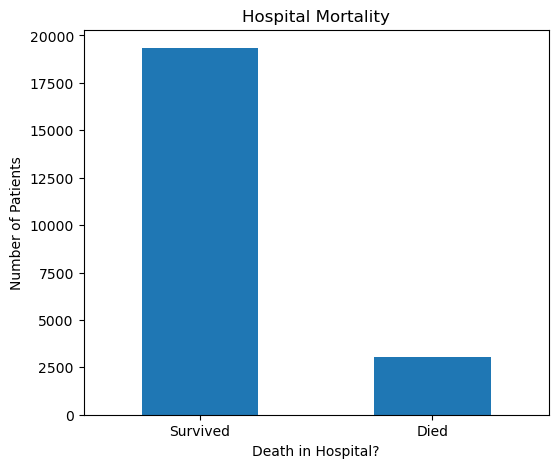

In [26]:
import matplotlib.pyplot as plt

# Print exact numbers of survived and died
counts = final_df["MORTALITY_INHOSPITAL"].value_counts()
print("Survived (0) :", counts.get(0, 0))
print("Died (1)     :", counts.get(1, 0))

# Plot bar chart
plt.figure(figsize=(6,5))
counts.plot(kind="bar")

plt.xticks([0,1], ["Survived", "Died"], rotation=0)
plt.xlabel("Death in Hospital?")
plt.ylabel("Number of Patients")
plt.title("Hospital Mortality")

plt.show()

In [27]:
from sklearn.feature_selection import mutual_info_classif

# --------------------------------------------------
# Remove ID columns (never used as features)
#(Here we remove ID columns (patient/admission/ICU IDs), because they are just identifiers and should not be used as predictors in the model.)
# --------------------------------------------------
id_cols = ["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"]
safe_final_df = final_df.drop(columns=[c for c in id_cols if c in final_df.columns])

# --------------------------------------------------
# Ensure target column exists and is numeric
# (We check that the target column MORTALITY_INHOSPITAL is present and convert it to 0/1 integers so we can calculate correlations.)
# --------------------------------------------------
target_col = "MORTALITY_INHOSPITAL"

if target_col not in safe_final_df.columns:
    raise ValueError(f"{target_col} not found in safe_final_df!")

safe_final_df[target_col] = safe_final_df[target_col].astype(int)

# --------------------------------------------------
# Numeric features – Pearson correlation
# (We take all numeric columns (except the target) and compute their Pearson correlation with mortality, then sort them from strongest to weakest relationship)
# --------------------------------------------------
numeric_cols = safe_final_df.select_dtypes(include=["number"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

numeric_df = safe_final_df[numeric_cols + [target_col]]

corr_with_target = (
    numeric_df.corr()[target_col]
    .drop(target_col)
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

numeric_rank = pd.DataFrame({
    "score": corr_with_target.abs(),   # importance = |r|
    "signed_corr": corr_with_target,   # store the sign separately
    "type": "numeric",
    "metric": "pearson_r"
})

# --------------------------------------------------
# Categorical features – Mutual Information
# (For non-numeric (categorical) columns, we turn the text into numbers and use mutual information to measure how much each category-based feature tells us about mortality)
# --------------------------------------------------
cat_cols = safe_final_df.select_dtypes(include=["object", "category"]).columns.tolist()

cat_rank = pd.DataFrame(columns=["score", "type", "metric"])

if len(cat_cols) > 0:
    X_cat = safe_final_df[cat_cols].copy()

    for col in cat_cols:
        X_cat[col] = X_cat[col].astype("category")
        X_cat[col] = X_cat[col].cat.add_categories("MISSING").fillna("MISSING")
        X_cat[col], _ = X_cat[col].factorize()

    mi_scores = mutual_info_classif(
        X_cat,
        safe_final_df[target_col],
        discrete_features=True,
        random_state=0
    )

    cat_rank = (
        pd.DataFrame({
            "feature": cat_cols,
            "score": mi_scores,
            "type": "categorical",
            "metric": "mutual_info",
        })
        .set_index("feature")
        .sort_values("score", ascending=False)
    )

# --------------------------------------------------
# Combine + sort all features
# --------------------------------------------------
feature_rank = pd.concat([numeric_rank, cat_rank]).sort_values("score", ascending=False)

top_n = 12
print(f"Top {top_n} most important features for hospital mortality:")
print(feature_rank.head(top_n))

Top 12 most important features for hospital mortality:
                   score  signed_corr         type       metric
Lactate_mean    0.238281     0.238281      numeric    pearson_r
AG_mean         0.236405     0.236405      numeric    pearson_r
Lactate_max     0.226266     0.226266      numeric    pearson_r
AG_max          0.225532     0.225532      numeric    pearson_r
BUN_min         0.207512     0.207512      numeric    pearson_r
Lactate_min     0.204071     0.204071      numeric    pearson_r
BUN_mean        0.202939     0.202939      numeric    pearson_r
GCS_mean        0.198649    -0.198649      numeric    pearson_r
Bilirubin_mean  0.187289     0.187289      numeric    pearson_r
Bilirubin_max   0.187039     0.187039      numeric    pearson_r
GCS_max         0.185089    -0.185089      numeric    pearson_r
DIAGNOSIS       0.165225          NaN  categorical  mutual_info


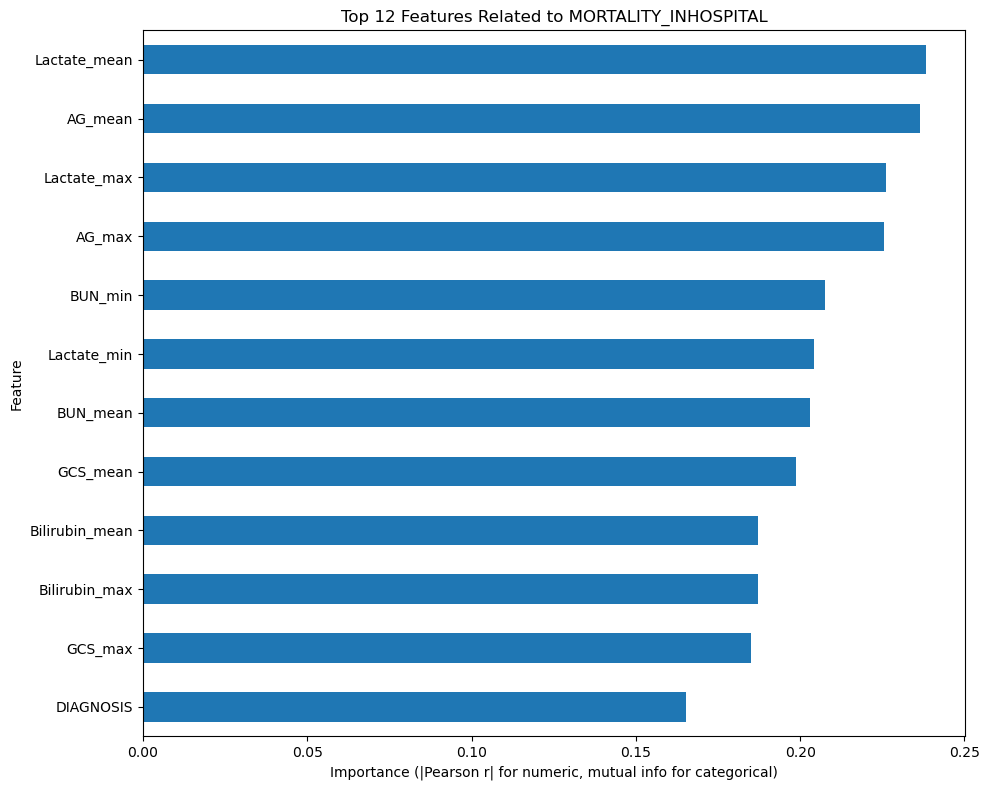

In [28]:
# --------------------------------------------------
# Bar plot of top N
# --------------------------------------------------
plt.figure(figsize=(10, 8))
(
    feature_rank.head(top_n)
    .sort_values("score")["score"]
    .plot(kind="barh")
)
plt.xlabel("Importance (|Pearson r| for numeric, mutual info for categorical)")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Features Related to {target_col}")
plt.tight_layout()
plt.show()


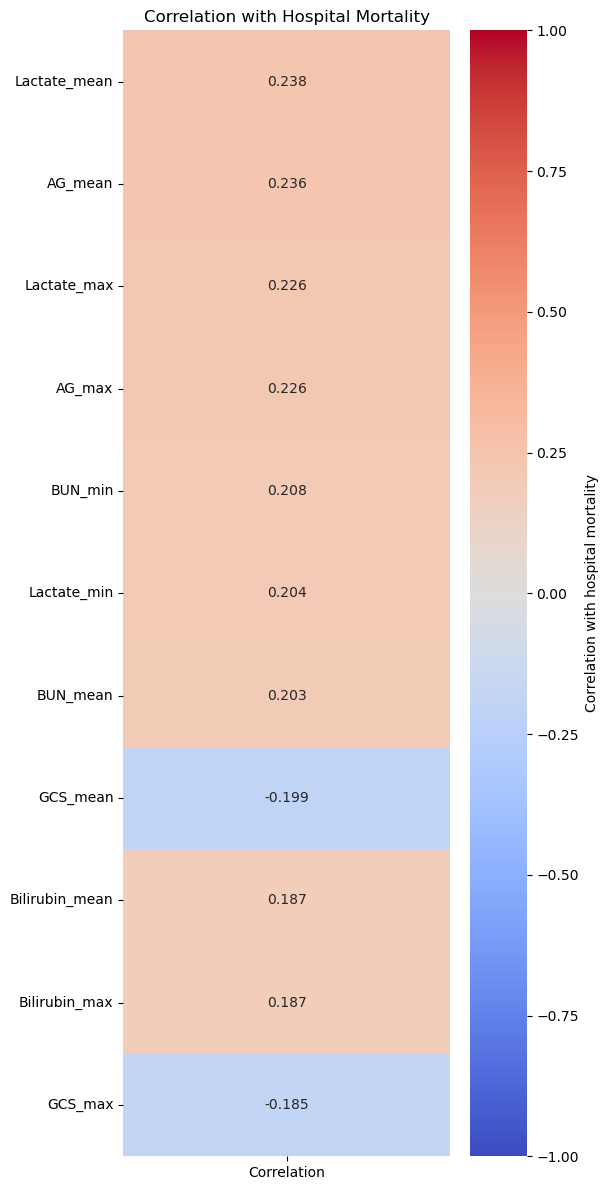

In [29]:
import seaborn as sns
corr_df = corr_with_target.to_frame(name="Correlation")

plt.figure(figsize=(6, 12))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    cbar_kws={"label": "Correlation with hospital mortality"}
)

plt.title("Correlation with Hospital Mortality")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [30]:
# ============================================================
# Imports
# ============================================================

import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

from xgboost import XGBClassifier


In [31]:
# ============================================================
# Configuration
# Keep all project knobs here (easy to review / change)
# ============================================================

TARGET = "MORTALITY_INHOSPITAL"   
TEXT_COL = "DIAGNOSIS"            

TEST_SIZE = 0.20
RANDOM_STATE = 42

In [83]:
# ============================================================
#  Load / clean data
# Minimal cleaning: keep transformations inside the pipeline
# ============================================================


# ID columns (don't use as predictors)
id_cols = ["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"]
id_cols = [c for c in id_cols if c in final_df.columns]

# Make sure DIAGNOSIS exists and is string
if TEXT_COL in final_df.columns:
    final_df[TEXT_COL] = final_df[TEXT_COL].fillna("unknown").astype(str)

# Separate X, y
df_model = final_df.dropna(subset=[TARGET]).copy()
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(int)

print("Total samples for modeling:", X.shape[0])

# Drop ID columns from X
X = X.drop(columns=id_cols, errors="ignore")

print("Features shape (after dropping IDs):", X.shape)
print("Target distribution (mean = mortality rate):", y.mean().round(3))

Total samples for modeling: 22365
Features shape (after dropping IDs): (22365, 12)
Target distribution (mean = mortality rate): 0.135


In [84]:
# ============================================================
# Feature typing
# Separate numeric, categorical, and free-text features explicitly
# ============================================================

numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
text_cols = [TEXT_COL] if TEXT_COL in X.columns else []
categorical_cols = [c for c in X.columns if c not in numeric_cols + text_cols]


print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))
print("Text feature:", TEXT_COL)



Numeric features: 11
Categorical features: 0
Text feature: DIAGNOSIS


In [92]:
# ============================================================
#  Preprocessing
# Right tool for each data type (numeric / categorical / text)
# ============================================================

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # robust default for clinical data
    ("scaler", StandardScaler())                    # helps LR converge and stabilizes coefficients
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # stable for discrete clinical fields
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     # safe for unseen categories at inference
])

text_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 4),     # captures phrases like "septic shock"
        min_df=2,              # drops rare diagnosis strings that overfit
        max_features=55000,      # keeps feature space manageable
        stop_words="english"
    ))
])

# Combine all feature processing into one object so it can be reused across models
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, categorical_cols),
        ("text", text_pipeline, TEXT_COL)
    ]
)

In [93]:
# ============================================================
# Define models
# Two methods: interpretable baseline + stronger non-linear model
# ============================================================

# Baseline: interpretable and easy to validate clinically
lr_model = Pipeline([
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(
        max_iter=4000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

# Candidate: non-linear learner (often improves AUROC with mixed features)
xgb_model = Pipeline([
    ("preprocess", preprocess),
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

In [94]:
# ============================================================
#  Train / test split
# Stratified split preserves outcome prevalence
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

In [95]:
# ============================================================
# Train models
# All preprocessing happens inside the pipeline — no data leakage
# ============================================================

lr_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GCS_max', 'GCS_mean',
                                                   'Lactate_min', 'Lactate_max',
                                                   'Lactate_mean', 'BUN_min',
                                                   'BUN_mean', 'AG_max',
                                                   'AG_mean', 'Bilirubin_max',
                                                   'Bilirubin_mean']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(st...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [96]:
# ============================================================
# Evaluate models (test set)
# ============================================================

def evaluate_model(name, fitted_model, X_test, y_test):
    y_pred = fitted_model.predict(X_test)
    y_proba = fitted_model.predict_proba(X_test)[:, 1]

    results = {
        "Model": name,
        "AUROC": roc_auc_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "y_proba": y_proba  # keep for ROC plotting
    }

    print(f"\n=== {name} (Test Set) ===")
    print(f"AUROC     : {results['AUROC']:.4f}")
    print(f"Accuracy  : {results['Accuracy']:.4f}")
    print(f"Precision : {results['Precision']:.4f}")
    print(f"Recall    : {results['Recall']:.4f}")
    print(f"F1-score  : {results['F1']:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return results

lr_results = evaluate_model("Logistic Regression", lr_model, X_test, y_test)
xgb_results = evaluate_model("XGBoost", xgb_model, X_test, y_test)




=== Logistic Regression (Test Set) ===
AUROC     : 0.7943
Accuracy  : 0.7590
Precision : 0.3171
Recall    : 0.6749
F1-score  : 0.4314

Confusion Matrix:
[[2986  881]
 [ 197  409]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      3867
           1       0.32      0.67      0.43       606

    accuracy                           0.76      4473
   macro avg       0.63      0.72      0.64      4473
weighted avg       0.85      0.76      0.79      4473


=== XGBoost (Test Set) ===
AUROC     : 0.8094
Accuracy  : 0.8802
Precision : 0.6989
Recall    : 0.2030
F1-score  : 0.3146

Confusion Matrix:
[[3814   53]
 [ 483  123]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93      3867
           1       0.70      0.20      0.31       606

    accuracy                           0.88      4473
   macro avg       0.79      0.59      0.62      4473
wei

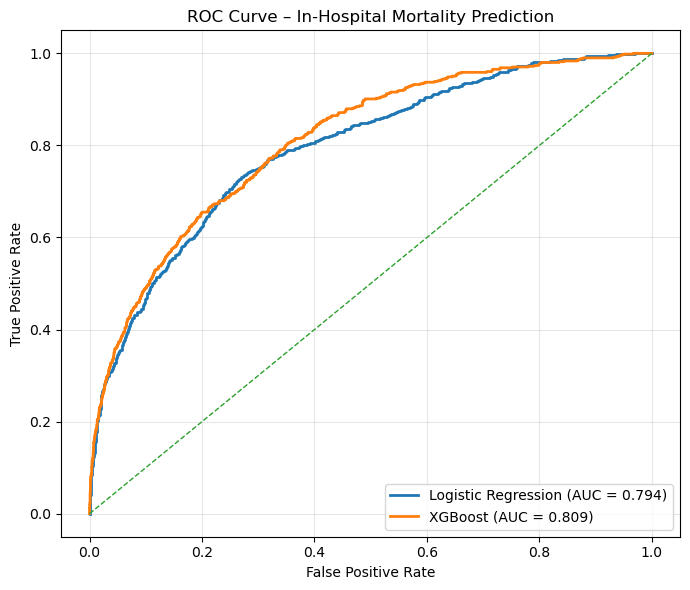

In [97]:
# ============================================================
# ROC curve comparison
# Single plot to compare discrimination performance
# ============================================================

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_results["y_proba"])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_results["y_proba"])

auc_lr = auc(fpr_lr, tpr_lr)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – In-Hospital Mortality Prediction")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [71]:
# ============================================================
# Save trained pipelines
# Save full pipelines so preprocessing is identical at inference time
# ============================================================

joblib.dump(lr_model, "mortality_logistic_tfidf.joblib")
joblib.dump(xgb_model, "mortality_xgboost_tfidf.joblib")

print("\nSaved:")
print(" - mortality_logistic_tfidf.joblib")
print(" - mortality_xgboost_tfidf.joblib")


Saved:
 - mortality_logistic_tfidf.joblib
 - mortality_xgboost_tfidf.joblib


In [76]:


# Load  trained model (choose one)
model = joblib.load("mortality_logistic_tfidf.joblib")
# model = joblib.load("mortality_xgboost_tfidf.joblib")


In [105]:
def interactive_mortality_prediction():
    print("\nEnter patient values \n")

    Lactate_mean     = float(input("Lactate_mean: "))
    AG_mean          = float(input("AG_mean: "))
    Lactate_max      = float(input("Lactate_max: "))
    AG_max           = float(input("AG_max: "))
    BUN_min          = float(input("BUN_min: "))
    Lactate_min      = float(input("Lactate_min: "))
    BUN_mean         = float(input("BUN_mean: "))
    GCS_mean         = float(input("GCS_mean: "))
    Bilirubin_mean   = float(input("Bilirubin_mean: "))
    Bilirubin_max    = float(input("Bilirubin_max: "))
    GCS_max          = float(input("GCS_max: "))
    DIAGNOSIS        = input("DIAGNOSIS (text): ")

    # Build one-row dataframe
    patient_df = pd.DataFrame([{
        "Lactate_mean": Lactate_mean,
        "AG_mean": AG_mean,
        "Lactate_max": Lactate_max,
        "AG_max": AG_max,
        "BUN_min": BUN_min,
        "Lactate_min": Lactate_min,
        "BUN_mean": BUN_mean,
        "GCS_mean": GCS_mean,
        "Bilirubin_mean": Bilirubin_mean,
        "Bilirubin_max": Bilirubin_max,
        "GCS_max": GCS_max,
        "DIAGNOSIS": DIAGNOSIS
    }])

    # Predict mortality probability
    prob = model.predict_proba(patient_df)[0, 1]

    print("\n----------------------------------")
    print(f"Predicted mortality probability: {prob:.3f}")
    print("----------------------------------")


In [111]:
interactive_mortality_prediction()


Enter patient values 



Lactate_mean:  1
AG_mean:  10
Lactate_max:  2
AG_max:  12
BUN_min:  7
Lactate_min:  0.5
BUN_mean:  14
GCS_mean:  14
Bilirubin_mean:  0.8
Bilirubin_max:  1
GCS_max:  15
DIAGNOSIS (text):  fever



----------------------------------
Predicted mortality probability: 0.035
----------------------------------
